In [1]:
from sympy import MatrixSymbol, Matrix, Identity

import sympy as sym
import math

sym.init_printing()
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import control

# IDENTIFICACIÓN DE SISTEMAS

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

# Identificación de Sistemas Dinámicos en Tiempo Discreto

## Ejemplo numérico

Se hace necesario recalcar que para la Identificación del sistema, se espera reconstruir el modelo a partir de las mediciones de las salidas y entradas y el objetivo entonces es obtener el vector de parámetros $\theta = [a_1, a_2,...,a_{n_a}, b_1, b_2,...,b_{n_b}]^T$.

$$y[t] = -a_1y[t-1]-...-a_{n_a}y[t-{n_a}] + b_1u[t-1]+b_2u[t-2]+...+b_{n_b}u[t-{n_b}] + e[t]$$

Conforme con la relación obtenida para el vector $\theta$, se podría reescribir este modelo así:

$$y[t] = \phi.\theta + e[t]$$

Por tanto para este caso, la matriz de regresión tendría la siguiente forma:

$$\phi = \begin{bmatrix}-y[t-1]&-y[t-2]&...&-y[t-{n_a}]&u[t-1]&u[t-2]&...&u[t-{n_b}]\end{bmatrix}$$


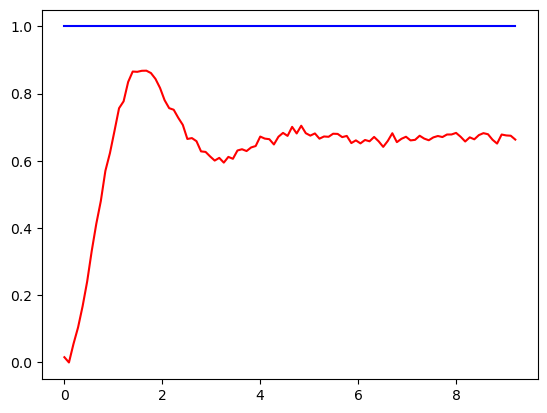

In [2]:
## Sistema de segundo orden en tiempo continuo
g = control.tf([6],[2,3,9])
t,y = control.step_response(g)
N = len(y)
u = np.ones(N);
dt = t[1]-t[0]


## Ruido para las señales
r = 0.01
e = np.random.normal(0,r,size=N)

yn = y+e

plt.plot(t,yn,color = 'red')
plt.plot(t,u,color = 'blue')

## Definir la matriz de regresión
$$\phi = \begin{bmatrix}-y[t-1]&-y[t-2]&...&-y[t-{n_a}]&u[t-1]&u[t-2]&...&u[t-{n_b}]\end{bmatrix}$$

In [15]:
## Definir y_1, y_2, y_3, dependiendo el sistema que se quiera modelar
y_1 = np.zeros(N)
y_2 = np.zeros(N)
u_1 = np.zeros(N)
u_2 = np.zeros(N)

for k in range(1,N):
    y_1[k]=yn[k-1]
    u_1[k]=u[k-1]
for k in range(2,N):
    y_2[k]=yn[k-2]
    u_2[k]=u[k-2]
    
## Creación del vector phi
phi = np.array([-y_1,-y_2,u_1,u_2]).transpose()
#phi = np.array([-y_1,-y_2,u_1]).transpose()
#phi = np.array([y_1,y_1]).transpose()

## Calculando los parámetros
$$\theta_{ls} = \phi^+.y[k]$$


La regresión lineal continúa siendo el modelo que se está estimando y la estimación de parámetros puede hacerse por los métodos de mínimos cuadrados discutidos con anterioridad.

In [16]:
# Parámetro para la regularización de los minimos cuadrados (entre 0 y 1)
# Garantiza que la matriz (phi^T*phi)^-1 exista y se pueda estimar 
#los parámetros.
alpha = 0.945
A = np.dot(phi.T,phi) + alpha*np.eye(len(np.dot(phi.T,phi)))
theta = np.dot(np.linalg.inv(A),np.dot(phi.T,yn))
theta

array([-0.40427851, -0.36476361,  0.15531557])

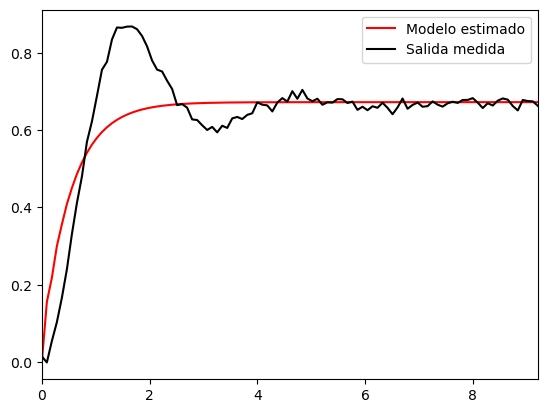

In [17]:
## Definir el modelo ARX    y(t) = G(z)u(t) + H(z)e(t)
## G = B/A,    H = 1/A
z = sym.symbols('z', complex=True)
s = sym.symbols('s', complex=True)
## EVALUAR LA SELECCIÓN DEL TIEMPO DE MUESTREO

## Construir los polinomios A(z) y B(z)
A = 1 + theta[0]*z**-1 + theta[1]*z**-2  
B = theta[2]*z**-1

G = B/A
G = G.simplify()
G_e = control.tf([-theta[2],0],[-1,-theta[0],-theta[1]],dt)

H = 1/A
H = H.simplify()
H_e = control.tf([-1,0,0],[-1,-theta[0],-theta[1]],dt)


## Intento 1 - respuesta discreta.
## Averiguar cómo obtener los mismos datos que yn

td,ye = control.step_response(G_e)
plt.plot(td,ye,color = 'red')
plt.plot(t,yn,color = 'black')
plt.legend(['Modelo estimado','Salida medida'])
plt.xlim([0, t[len(t)-1]])   

ECM = np.sqrt(np.dot((yn-ye[0:100]).transpose(),(yn-ye[0:100])))/len(yn)

In [14]:
## Función de transferencia G(z)
print(G_e, H_e)
print(ECM)


        -0.1999
------------------------
-z^2 + 0.6948 z - 0.1999

dt = 0.09303374113107254
 
          -z^2
------------------------
-z^2 + 0.6948 z - 0.1999

dt = 0.09303374113107254

0.008330438483206234
